# comparing : 
* random search 
* labmate Ai 
* Bayesien Optimization with  Expected improvement 
* Bayesien Optimization with  probability improvement 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys 
import time
import random
from tqdm import tqdm
import time
from numpy.linalg import inv
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.externals.joblib import dump
from sklearn import model_selection 
from sklearn.model_selection import GridSearchCV, cross_val_score,StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import validation_curve,ShuffleSplit
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor,  RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from utils import *


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [23]:
df = pd.read_excel('5760_simple_discriptors-SMILES.xlsx')
data = df.drop([ 'Reaction_No', 'SMILES', 'Catalyst_1_Short_Hand','SMILES_R1','SMILES_R2','SMILES','SMILES_LI','SMILES_BASE','SMILES_SOLV'], axis=1 )
data_used = data.dropna(axis=0 , how='any')

# dropping missed values
data_used = data_used.reset_index().drop('index', axis=1).copy()

# Normalization of continuous variables 
data_used['Product_Yield_PCT_Area_UV'] = data_used['Product_Yield_PCT_Area_UV']/100

xls = pd.ExcelFile('Descriptors for Computational Modelling.xlsx')
df_Bases = pd.read_excel(xls, 'Base_Short_Hand')
df_Solvents = pd.read_excel(xls, 'Solvent_1_Short_Hand')
df_Ligands = pd.read_excel(xls, 'Ligand_Short_Hand')

# one hot encoding
data_ohe = data_cleaning(data_used)
Y_ohe = data_ohe["Product_Yield_PCT_Area_UV"]
data_ohe = data_ohe.drop('Product_Yield_PCT_Area_UV', axis=1)
X_ohe = pd.get_dummies(data_ohe)

# discreptors
df_descr = data_discreptors(data_used,xls,df_Ligands,df_Bases,df_Solvents)
Y_just_descri = df_descr["Product_Yield_PCT_Area_UV"]
df = df_descr.drop(['Product_Yield_PCT_Area_UV',"Ligand_Short_Hand","Base_Short_Hand","Solvent_1_Short_Hand"], axis=1)
X_just_descri = pd.get_dummies(df)
df_descr = X_just_descri.copy()
df_descr["Product_Yield_PCT_Area_UV"] = Y_just_descri.copy()

In [24]:
def  cross_validations_plots(X,Y,n_splits = 4):
     
    #CV = [KFold,ShuffleSplit]
    CV = [ShuffleSplit]
    cv_results = []
    n_splits = 4
    for cv in CV :
        this_cv = cv(n_splits=n_splits)
        result = -cross_val_score(RandomForestRegressor(200), X, Y, cv=this_cv, scoring='neg_root_mean_squared_error') 
        cv_results.append(result)        
        
    cv_means = []
    cv_std = []
    for cv_result in cv_results:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())

    cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["ShuffleSplit"]})
    return cv_res
    #g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
    #g.set_xlabel("Mean Root Mean Squared Error Cross Validation")
    #g = g.set_title("4-fold cross validation with " + data_type + " data")  
    
    
    

# Aquisition functions

In [25]:
def expected_improvement_RF(model,X_unseen,X_train,y_train,xi=0.01):
    model.fit(X_train,y_train)
    dim = X_train.shape[1]
    
    all_predictions = []
    for e in model.estimators_:
        all_predictions += [e.predict(X_unseen)]
    
    variance = np.var(all_predictions, axis=0)
    sigma = np.sqrt(variance)
    
    mu = model.predict(X_unseen) 
    mu_sample = model.predict(X_train) 
    
    
    sigma = sigma.reshape(-1, X_unseen.shape[0])
    
    mu_sample_opt = np.max(mu_sample) 

    with np.errstate(divide='warn'): 
        imp = mu - mu_sample_opt - xi 
        Z = imp / sigma 
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z) 
        ei[sigma == 0.0] = 0.0 
    
    
    ei_df = pd.DataFrame(data=ei.reshape(-1,ei.shape[0]), columns=['expected_improvement_RF'],index = X_unseen.index)  
    predictions = model.predict(X_unseen)
    predictions_df = pd.DataFrame(data=predictions, columns=['Prediction'],index = X_unseen.index)
    assert len(ei_df) == len(predictions) # control line
    initial_data = pd.DataFrame(data=X_unseen, columns = list(X_unseen.columns.values),index = X_unseen.index)
    df = pd.concat([initial_data, predictions_df, ei_df], axis=1)
    return df 

def probability_of_improvement(model,X_unseen,X_train,y_train):
    model.fit(X_train,y_train)
    dim = X_train.shape[1]
    
    all_predictions = []
    for e in model.estimators_:
        all_predictions += [e.predict(X_unseen)]
    
    variance = np.var(all_predictions, axis=0)
    sigma = np.sqrt(variance)
    
    mu = model.predict(X_unseen) 
    mu_sample = model.predict(X_train) 
    
    
    sigma = sigma.reshape(-1, X_unseen.shape[0])
    
    mu_sample_opt = np.max(mu_sample) 

    with np.errstate(divide='warn'):          
        pi = norm.cdf((mu - mu_sample_opt)/(sigma+1E-9)) 
    
    
    pi_df = pd.DataFrame(data=pi.reshape(-1,pi.shape[0]), columns=['probability_of_improvement'])  
    predictions = model.predict(X_unseen)
    predictions_df = pd.DataFrame(data=predictions, columns=['Prediction'])
    assert len(pi_df) == len(predictions) # control line
    #initial_data = pd.DataFrame(data=X_unseen, columns = list(X_unseen.columns.values))
    #df = pd.concat([initial_data, predictions_df, pi_df], axis=1)
    df = pd.concat([predictions_df, pi_df], axis=1)
    return df

# test 
#model = RandomForestRegressor(200)
#X_train, X_test,y_train, y_test = train_test_split(X_just_descri, Y_just_descri, train_size=0.06, random_state = 2)
#pi_values = probability_of_improvement(model,X_test,X_train,y_train).iloc[:100,-1]
#plt.figure(figsize=(20,6))
#plt.plot(ei_values,'or', label='Expected improvement')
#plt.xlabel('Iteration')
#plt.ylabel(' yield')
#plt.legend()

# Defining chemical space

In [26]:
#### Defining chemical space for simulating navigation of reaction space
class ChemicalSpace():
    ''' Abstract class of chemical space for simulating navigation of 
        reaction space using machine learning'''
    
    def __init__(self, df, seed=None):
        # seed for reproduciibity
        random.seed(seed)
        self.df = df
        self.index = list(df.index)
        self.explored_space_index = []
        self.space_len = len(self.index)
        # randomize the indexes
        random.shuffle(self.index)
        
        
    def random_guess(self,number_initial_data):
        '''Returns the dataframe with random rxns from chemical space'''
        num_of_rxns = number_initial_data    
        random_rxns_idxs = []        
        for idx  in self.index:
            if idx not in self.explored_space_index:
                self.explored_space_index.append(idx)
                random_rxns_idxs.append(idx)
                if len(random_rxns_idxs) == num_of_rxns:
                    break
        random_df = self.df.loc[random_rxns_idxs]
        return random_df
    
    
    def get_unused(self):
        ''' Return a dataframe of all reactions which has not been explored so far'''
        
        unused_rxn_idxs = []
        
        for idx in self.index:
            if idx not in self.explored_space_index:
                unused_rxn_idxs.append(idx)
                
        unused_rxns = self.df.loc[unused_rxn_idxs]
        return unused_rxns
        
    def get_explored(self):
        ''' Return a dataframe with indexes of reactions which have been chosen'''
        
        return self.df.loc[self.explored_space_index]
    
    def update_explored_rxns(self, rxn_idxs):
        ''' Add rxn_idxs to the list of explored reactions'''
        self.explored_space_index += rxn_idxs
        
    def is_empty(self):
        ''' Return True if the whole chemical space has been explored'''
        if len(self.explored_space_index) == self.space_len:
            return True
        else:
            return False
        
    def percent_explored(self):
        ''' Return the percent of exploration of chemical space'''
        return len(self.explored_space_index)/self.space_len


# Exploration of chemical space

In [32]:
#### Exploration of chemical space
class Simulation():
    def __init__(self, model, data,method,screen_size,number_initial_data,test_print,max_iter):
        self.data = data
        self.chemspace = ChemicalSpace(data, )
        self.method = method
        self.screen_size = screen_size
        self.max_real_yield = []
        self.number_initial_data = number_initial_data
        self.test_print = test_print
        self.max_iter = max_iter 
        self.RMSE_mean = []
        self.RMSE_sd = []
        self.model = model
        
 
    
    def explore_space(self): 
        
        # define the model                 
        model = self.model 
        
        # randomly guess select k reactions from chemical space
        random_guess = self.chemspace.random_guess(self.number_initial_data)        

        # Evaluate average yield of selected reactions
        self.max_real_yield = [np.mean(random_guess['Product_Yield_PCT_Area_UV'])]    
        
        # Evaluate the RMSE of the random selected reactions
        X_train , y_train = shuffle(random_guess.drop('Product_Yield_PCT_Area_UV', axis=1),
                                    random_guess['Product_Yield_PCT_Area_UV'])
        cv_res = cross_validations_plots(X_train , y_train,n_splits = 4)
        self.RMSE_mean.append(cv_res["CrossValMeans"].values) 
        self.RMSE_sd.append(cv_res["CrossValerrors"].values) 

        
        
        
        
        iteration = 1
        best_idxs = []
        
        
        while not self.chemspace.is_empty() and iteration < self.max_iter:
        #while not self.chemspace.is_empty():
            
            # split data for reactions explored so far           
            X_train , y_train = shuffle(self.chemspace.get_explored().drop('Product_Yield_PCT_Area_UV', axis=1),
                                        self.chemspace.get_explored()['Product_Yield_PCT_Area_UV'])
                                                
            # train the random forest on this data
            model.fit(X_train,y_train)
            

            
            
            # Get a dataframe with all reaction which hasn't been performed
            unseen = self.chemspace.get_unused()
                        
            X_unseen = unseen.drop('Product_Yield_PCT_Area_UV', axis=1).copy()
            
            
            ##################################
            # choose the exploration strategy#   
            ##################################
            
            if (self.method == 'Labmate_Ai'):                
                yp = model.predict(X_unseen)
                unseen[self.method] = yp
                sorted_by = unseen.sort_values(by=[self.method],ascending=False)
                                                
            if (self.method == 'expected_improvement_RF'):
                X_unseen = unseen.drop('Product_Yield_PCT_Area_UV', axis=1)
                unseen[self.method] = expected_improvement_RF(model,X_unseen,X_train,y_train,xi=0.01)[self.method].values
                sorted_by = unseen.sort_values(by=[self.method],ascending=False)

            
            if (self.method == 'probability_of_improvement'):
                X_unseen = unseen.drop('Product_Yield_PCT_Area_UV', axis=1)
                unseen[self.method] = probability_of_improvement(model,X_unseen,X_train,y_train)[self.method].values
                sorted_by = unseen.sort_values(by=[self.method],ascending=False)
                
            if (self.method == "random_search"):
                unseen.sample(n=len(unseen))
                unseen[self.method] = unseen['Product_Yield_PCT_Area_UV'].values
                sorted_by = unseen
                
            
            

                    
            # Get a dataframe with best candidates from method chosen.
            best_results = sorted_by.head(self.screen_size)
                        
            # Get idxs of best candidates 
            best_results_idxs = list(best_results.index) 
            best_idxs = best_idxs + best_results_idxs    
            
            # Get idxs of best candidates 
            best_results_idxs = list(best_results.index) 
                                                            
            # Evaluate real yiled of selected batch of reactions 
            f_star = np.mean(best_results['Product_Yield_PCT_Area_UV'])
            self.max_real_yield.append(f_star)           
            
            
            # Evaluate the RMSE of the selected batches so far
            cv_res = cross_validations_plots(X_train , y_train,n_splits = 4)
            self.RMSE_mean.append(cv_res["CrossValMeans"].values) 
            self.RMSE_sd.append(cv_res["CrossValerrors"].values) 
            

            
            
            

            # Add the current batch of reactions to explored reactions so in the next iteration RF can be trained on updated data    
            self.chemspace.update_explored_rxns(best_results_idxs)
                        
                
          
            if self.test_print == True:
                if iteration % 10 == 0:
                    print(f" the yield at iteration {iteration} is {f_star}")
                    print(f" X_train.shape : {X_train.shape} ")
                    print(f" X_test.shape  : {X_unseen.shape} ")
            
            iteration += 1
        
        
        
                                    
        # Create a data frame 
        stat_dataframe = pd.DataFrame()
        stat_dataframe['avg_real_yield'] = self.max_real_yield  
        stat_dataframe['RMSE_mean'] = self.RMSE_mean
        stat_dataframe['RMSE_sd'] = self.RMSE_sd

        return stat_dataframe


# RF Vs MLP learning curve : how many experiment we need ?

In [38]:
def learning_curve(model,df_descr,method,screen_size,number_initial_data,test_print,max_iter):
    t1 = time.time()
    simulation = Simulation(model,df_descr,method,screen_size,number_initial_data,test_print,max_iter)
    stat_dataframe = simulation.explore_space()

    xfit = np.arange(number_initial_data,number_initial_data + max_iter*screen_size , screen_size)
    max_real_yield = stat_dataframe['avg_real_yield']
    RMSE_mean = stat_dataframe['RMSE_mean']
    RMSE_sd = stat_dataframe['RMSE_sd']


    #plt.figure(figsize=(15,6))
    plt.plot(xfit,max_real_yield)
    plt.title('average yield per batch for expected improvement method')
    plt.xlabel('Reaction Number')
    plt.ylabel('Max Yield [%]')
    plt.pause(0.2)

    #plt.figure(figsize=(15,6))
    xfit = np.arange(number_initial_data,number_initial_data + max_iter*screen_size , screen_size)

    plt.plot(xfit,RMSE_mean, 'or')
    plt.plot(xfit,RMSE_mean, '-', color='gray')
    #xfit = np.arange(1,len((RMSE_mean))+1)*screen_size
    plt.fill_between(xfit, (RMSE_mean - RMSE_sd).astype(np.float), (RMSE_mean + RMSE_sd).astype(np.float), color='red', alpha=0.2)
    plt.plot(xfit,RMSE_mean, label='RMSE')

    plt.xlabel('Reactions')
    plt.ylabel('RMSE')
    plt.legend()
    t2 = time.time()
    print(f" one simulation with {max_iter} iteration is {(t2-t1)/60} min")

### random forest : screen_size = 30 : 
##### plot 1 : average of true yield in avery batch
##### plot 2 : the updated RMSE after every selection 

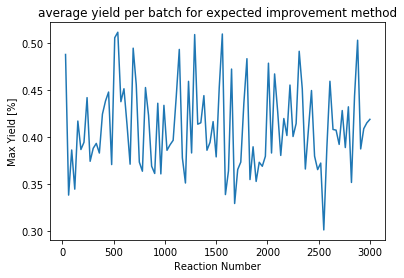

 one simulation with 100 iteration is 6.696041492621104 min


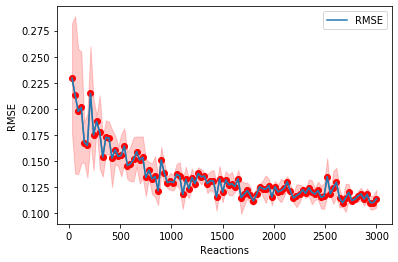

In [39]:
test_print = False
max_iter = 100
screen_size = 30
number_initial_data = 30
method = 'random_search'
model = RandomForestRegressor(500,n_jobs = -1)
learning_curve(model,df_descr,method,screen_size,number_initial_data,test_print,max_iter)

### neural_network : MLPRegressor : screen_size = 30
##### plot 1 : average of true yield in avery batch
##### plot 2 : the updated RMSE after every selection 

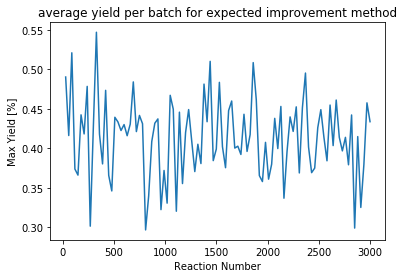

 one simulation with 100 iteration is 5.404919143517812 min


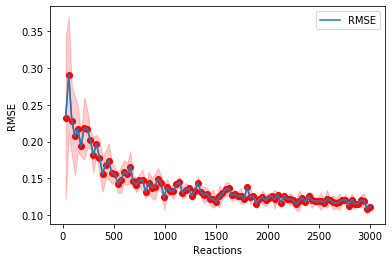

In [40]:
test_print = False
max_iter = 100
screen_size = 30
number_initial_data = 30
method = 'random_search'
model = MLPRegressor(hidden_layer_sizes=(200),
                       activation='logistic',
                       solver='sgd',
                       max_iter=10000)
learning_curve(model,df_descr,method,screen_size,number_initial_data,test_print,max_iter)

# Comparing : 
- LAbmateAi  
- Excpected improvement 
- Probability Improvememnt 
- random search

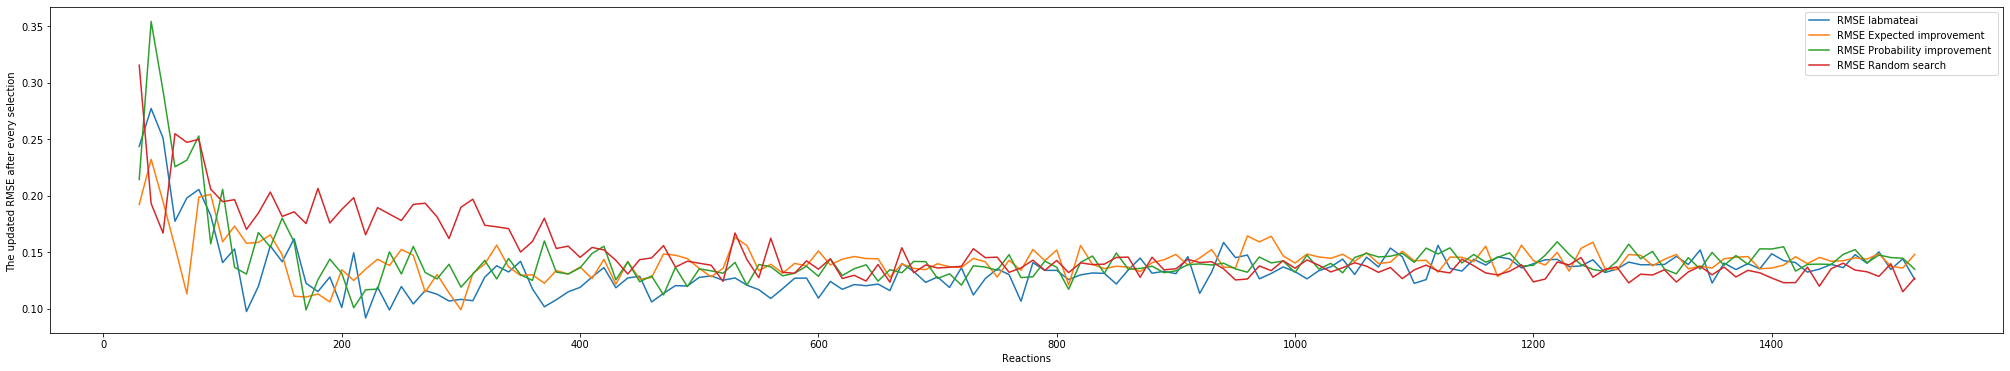

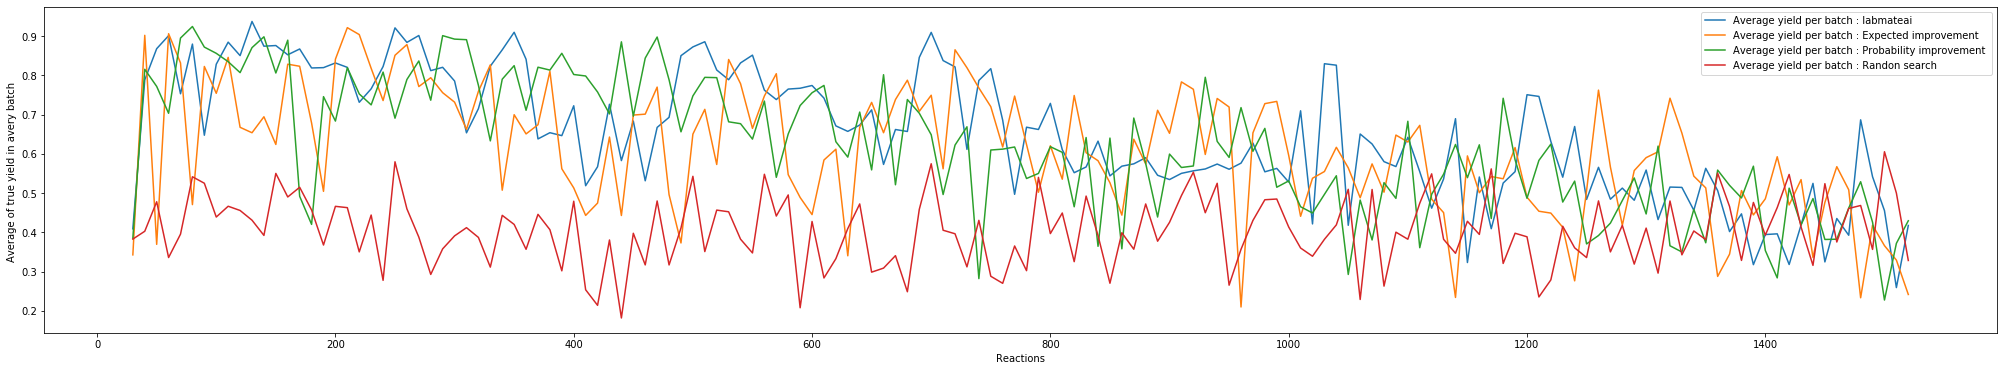

In [44]:
test_print = False
max_iter = 150
screen_size = 10
number_initial_data = 30
model = model = RandomForestRegressor(500,n_jobs = -1)


# labmateai
method = "Labmate_Ai"
simulation_labmateai = Simulation(model,df_descr,method,screen_size,number_initial_data,test_print,max_iter)
stat_dataframe_labmateai = simulation_labmateai.explore_space()
avg_real_yield_labmateai = stat_dataframe_labmateai['avg_real_yield']
RMSE_mean_labmateai = stat_dataframe_labmateai['RMSE_mean']

# Expected improvement  
method = "expected_improvement_RF"
simulation_EI = Simulation(model,df_descr,method,screen_size,number_initial_data,test_print,max_iter)
stat_dataframe_EI = simulation_EI.explore_space()
avg_real_yield_EI = stat_dataframe_EI['avg_real_yield']
RMSE_mean_EI = stat_dataframe_EI['RMSE_mean']

# Probability improvement  
method = "probability_of_improvement"
simulation_PI = Simulation(model,df_descr,method,screen_size,number_initial_data,test_print,max_iter)
stat_dataframe_PI = simulation_PI.explore_space()
avg_real_yield_PI = stat_dataframe_PI['avg_real_yield']
RMSE_mean_PI = stat_dataframe_PI['RMSE_mean']

#Random search 
method = "random_search"
simulation_RS = Simulation(model,df_descr,method,screen_size,number_initial_data,test_print,max_iter)
stat_dataframe_RS = simulation_RS.explore_space()
avg_real_yield_RS = stat_dataframe_RS['avg_real_yield']
RMSE_mean_RS = stat_dataframe_RS['RMSE_mean']



xfit = np.arange(number_initial_data,number_initial_data + max_iter*screen_size , screen_size)

plt.figure(figsize=(35,6))
plt.plot(xfit,RMSE_mean_labmateai, '-', label='RMSE labmateai')
plt.plot(xfit,RMSE_mean_EI, '-', label='RMSE Expected improvement')
plt.plot(xfit,RMSE_mean_PI, '-', label='RMSE Probability improvement ')
plt.plot(xfit,RMSE_mean_RS, '-', label='RMSE Random search')
plt.xlabel('Reactions')
plt.ylabel('The updated RMSE after every selection ')
plt.legend()

plt.pause(0.1)

plt.figure(figsize=(35,6))
plt.plot(xfit,avg_real_yield_labmateai, '-', label='Average yield per batch : labmateai')
plt.plot(xfit,avg_real_yield_EI, '-', label='Average yield per batch : Expected improvement')
plt.plot(xfit,avg_real_yield_PI, '-', label='Average yield per batch : Probability improvement ')
plt.plot(xfit,avg_real_yield_RS, '-', label='Average yield per batch : Randon search')
plt.xlabel('Reactions')
plt.ylabel('Average of true yield in avery batch ')
plt.legend()


# Simulations & Averaving  

In [54]:
def simulations(n_simu = 2):
    test_print = False
    max_iter = 100
    screen_size = 10
    number_initial_data = 30
    model = RandomForestRegressor(500,n_jobs = -1)
    
    Av_labmateai_y = []
    Av_ei_y = []
    Av_pi_y = []
    Av_rs_y = []

    Av_labmateai_rmse = []
    Av_ei_rmse = []
    Av_pi_rmse = []
    Av_rs_rmse = []
        
    
    
    
    k = 1
    t1 = time.time()
    for _ in range(n_simu):
        
        #print(f" iteration {k}")
        
        
        # labmateai
        method = "Labmate_Ai"
        simulation_labmateai = Simulation(model,df_descr,method,screen_size,number_initial_data,test_print,max_iter)
        stat_dataframe_labmateai = simulation_labmateai.explore_space()
        avg_real_yield_labmateai = stat_dataframe_labmateai['avg_real_yield']
        RMSE_mean_labmateai = stat_dataframe_labmateai['RMSE_mean']

        # Expected improvement  
        method = "expected_improvement_RF"
        simulation_EI = Simulation(model,df_descr,method,screen_size,number_initial_data,test_print,max_iter)
        stat_dataframe_EI = simulation_EI.explore_space()
        avg_real_yield_EI = stat_dataframe_EI['avg_real_yield']
        RMSE_mean_EI = stat_dataframe_EI['RMSE_mean']

        # Probability improvement  
        method = "probability_of_improvement"
        simulation_PI = Simulation(model,df_descr,method,screen_size,number_initial_data,test_print,max_iter)
        stat_dataframe_PI = simulation_PI.explore_space()
        avg_real_yield_PI = stat_dataframe_PI['avg_real_yield']
        RMSE_mean_PI = stat_dataframe_PI['RMSE_mean']

        #Random search 
        method = "random_search"
        simulation_RS = Simulation(model,df_descr,method,screen_size,number_initial_data,test_print,max_iter)
        stat_dataframe_RS = simulation_RS.explore_space()
        avg_real_yield_RS = stat_dataframe_RS['avg_real_yield']
        RMSE_mean_RS = stat_dataframe_RS['RMSE_mean']

        
        
        
        Av_labmateai_y.append(avg_real_yield_labmateai)
        Av_ei_y.append(avg_real_yield_EI)
        Av_pi_y.append(avg_real_yield_PI)
        Av_rs_y.append(avg_real_yield_RS)
        
        
        
        Av_labmateai_rmse.append(RMSE_mean_labmateai)
        Av_ei_rmse.append(RMSE_mean_EI)
        Av_pi_rmse.append(RMSE_mean_PI)
        Av_rs_rmse.append(RMSE_mean_RS)
        
        
        
        k += 1
        
    t2 = time.time()
    print( "time : " + str((t2-t1)/60) + " min")
        
        
        
        
        
    av_labmateai_y = np.mean(np.array(Av_labmateai_y),axis =0)
    av_ei_y = np.mean(np.array(Av_ei_y),axis =0)
    av_pi_y = np.mean(np.array(Av_pi_y),axis =0)
    av_rs_y = np.mean(np.array(Av_rs_y),axis =0)
    
    
    
    av_labmateai_rmse = np.mean(np.array(Av_labmateai_rmse),axis =0)
    av_ei_rmse = np.mean(np.array(Av_ei_rmse),axis =0)
    av_pi_rmse = np.mean(np.array(Av_pi_rmse),axis =0)
    av_rs_rmse = np.mean(np.array(Av_rs_rmse),axis =0)
    
    
    ###############################################################    
    # plot  : All strategies : yiels & RMSE averaging
    ###############################################################    
    
    xfit = np.arange(number_initial_data,number_initial_data + max_iter*screen_size , screen_size)

    plt.figure(figsize=(35,6))
    plt.plot(xfit,av_labmateai_rmse, '-', label='RMSE labmateai')
    plt.plot(xfit,av_ei_rmse, '-', label='RMSE Expected improvement')
    plt.plot(xfit,av_pi_rmse, '-', label='RMSE Probability improvement ')
    plt.plot(xfit,av_rs_rmse, '-', label='RMSE Random search')
    plt.xlabel('Reactions')
    plt.ylabel('The average of the updated RMSE after every selection ')
    plt.legend()

    plt.pause(0.1)

    plt.figure(figsize=(35,6))
    plt.plot(xfit,av_labmateai_y, '-', label='Average yield per batch : labmateai')
    plt.plot(xfit,av_ei_y, '-', label='Average yield per batch : Expected improvement')
    plt.plot(xfit,av_pi_y, '-', label='Average yield per batch : Probability improvement ')
    plt.plot(xfit,av_rs_y, '-', label='Average yield per batch : Randon search')
    plt.xlabel('Reactions')
    plt.ylabel('the Average of the Averages of true yield in every batch ')
    plt.legend()

time : 420.5684376994769 min


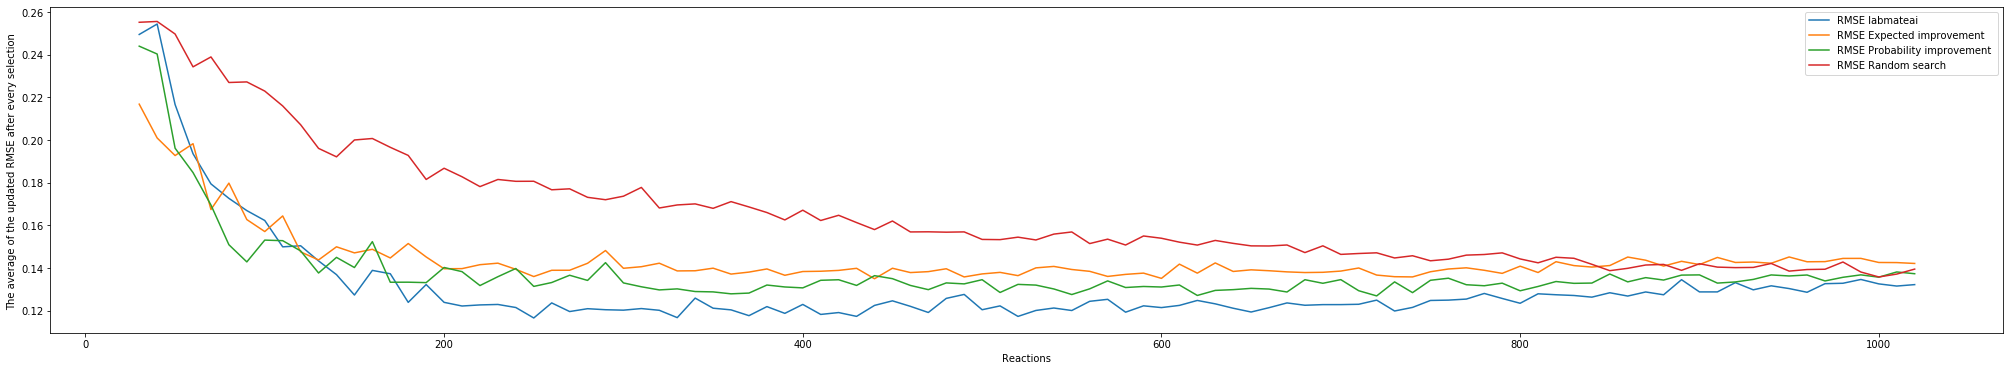

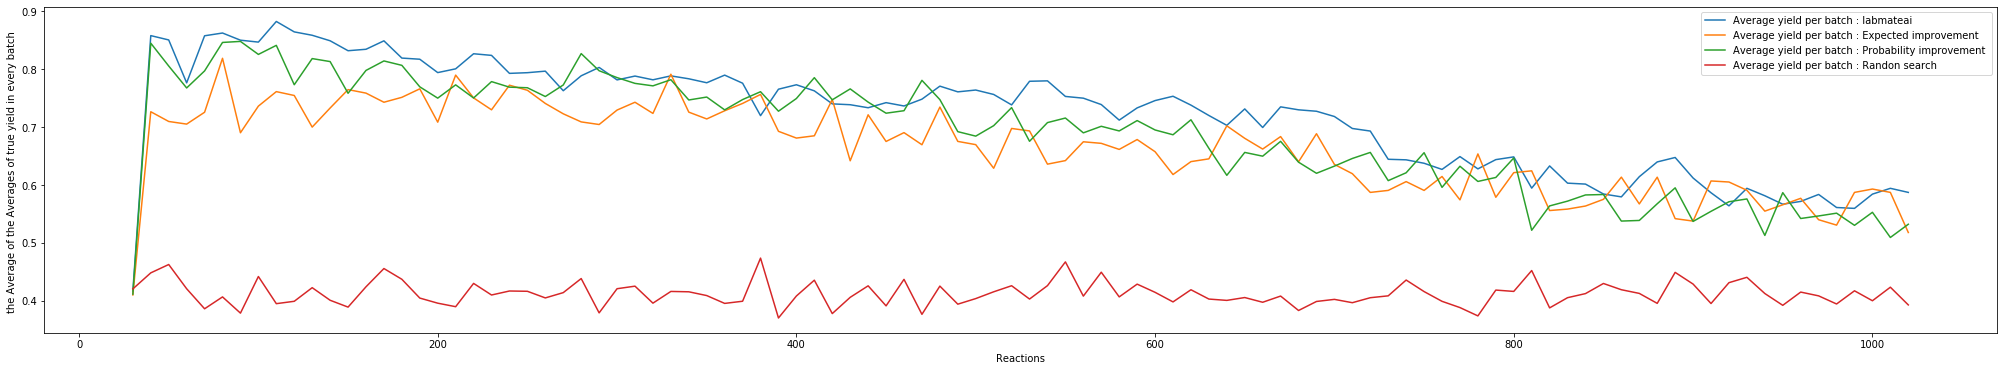

In [55]:
simulations(n_simu = 20)